In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import yaml
from PIL import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sys.path

['/Users/xuzhongwei/Source/ai/Maskrcnn/samples/shapes',
 '/Users/xuzhongwei/anaconda3/lib/python37.zip',
 '/Users/xuzhongwei/anaconda3/lib/python3.7',
 '/Users/xuzhongwei/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/Users/xuzhongwei/anaconda3/lib/python3.7/site-packages',
 '/Users/xuzhongwei/anaconda3/lib/python3.7/site-packages/aeosa',
 '/Users/xuzhongwei/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/Users/xuzhongwei/.ipython']

In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [5]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 1 class、クラスは何種類があるかを上げること

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8 * 6, 16 * 6, 32 * 6, 64 * 6, 128 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

In [12]:
iter_num = 0
class DrugDataset(utils.Dataset):
    # 得到该图中有多少个实例（物体）
    def get_obj_index(self, image):
        n = np.max(image)
        return n

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read())
            labels = temp['label_names']
            del labels[0]
        return labels

    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image, image_id):
        # print("draw_mask-->",image_id)
        # print("self.image_info",self.image_info)
        info = self.image_info[image_id]
        # print("info-->",info)
        # print("info[width]----->",info['width'],"-info[height]--->",info['height'])
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    # print("image_id-->",image_id,"-i--->",i,"-j--->",j)
                    # print("info[width]----->",info['width'],"-info[height]--->",info['height'])
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask

    # 重新写load_shapes，里面包含自己的自己的类别
    # 并在self.image_info信息中添加了path、mask_path 、yaml_path
    # yaml_pathdataset_root_path = "/tongue_dateset/"
    # img_floder = dataset_root_path + "rgb"
    # mask_floder = dataset_root_path + "mask"
    # dataset_root_path = "/tongue_dateset/"
    def load_shapes(self, count, img_floder, mask_floder, imglist, dataset_root_path):
        import skimage.io
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "hole")  #cocoデータのラベル(ここはhole)の名前を追加する
        self.add_class("shapes", 2, "damage")  #cocoデータのラベル(ここはdamage)の名前を追加する
        for i in range(count):
            # 获取图片宽和高

            filestr = imglist[i].split(".")[0]
            # print(imglist[i],"-->",cv_img.shape[1],"--->",cv_img.shape[0])
            # print("id-->", i, " imglist[", i, "]-->", imglist[i],"filestr-->",filestr)
            # filestr = filestr.split("_")[1]
            mask_path = mask_floder + "/" + filestr + ".png"
            yaml_path = dataset_root_path + "/labelme_json/" + filestr + "_json/info.yaml"
            print(img_floder + "/" + imglist[i])
            cv_img = cv2.imread(dataset_root_path + "/labelme_json/" + filestr + "_json/img.png")
            cv_img = skimage.color.gray2rgb(cv_img)
            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                          width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)

    # 重写load_mask

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        #print("image_id", image_id)
        info = self.image_info[image_id]
        count = 1  # number of object
        
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img, image_id)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion

            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels = []
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("hole") != -1:#cocoデータのラベル(ここはhole)の名前を追加する
                # print "box"
                labels_form.append("hole")
            elif labels[i].find("damage") != -1:#cocoデータのラベル(ここはdamage)の名前を追加する
                # print "box"
                labels_form.append("damage")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)

In [13]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

def train_model():
    # 基础设置
    dataset_root_path = "../../rail_train_data"#トレリングのデーターの相対パスを書く
    img_floder = os.path.join(dataset_root_path, "pic")
    mask_floder = os.path.join(dataset_root_path, "cv2_mask")
    # yaml_floder = dataset_root_path
    imglist = os.listdir(img_floder)
    count = len(imglist)
    
    # train与val数据集准备
    dataset_train = DrugDataset()
    dataset_train.load_shapes(count, img_floder, mask_floder, imglist, dataset_root_path)
    dataset_train.prepare()

    # print("dataset_train-->",dataset_train._image_ids)

    dataset_val = DrugDataset()
    dataset_val.load_shapes(7, img_floder, mask_floder, imglist, dataset_root_path)
    dataset_val.prepare()   

    # Create models in training mode
    config = ShapesConfig()
    config.display()
    model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

    # Which weights to start with?
    # 第一次训练时，这里填coco，在产生训练后的模型后，改成last
    init_with = "coco"  # imagenet, coco, or last

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        # Load weights trained on MS COCO, but skip layers that
        # are different due to the different number of classes
        # See README for instructions to download the COCO weights
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        # Load the last models you trained and continue training
        checkpoint_file = model.find_last()
        model.load_weights(checkpoint_file, by_name=True)

    # Train the head branches
    # Passing layers="heads" freezes all layers except the head
    # layers. You can also pass a regular expression to select
    # which layers to train by name pattern.
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=1,
                layers='heads')

    # Fine tune all layers
    # Passing layers="all" trains all layers. You can also
    # pass a regular expression to select which layers to
    # train by name pattern.
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE / 10,
                epochs=1,
                layers="all")

In [14]:
train_model()

../../rail_train_data/pic/000026.jpg
../../rail_train_data/pic/000032.jpg
../../rail_train_data/pic/000033.jpg
../../rail_train_data/pic/000027.jpg
../../rail_train_data/pic/000019.jpg
../../rail_train_data/pic/000031.jpg
../../rail_train_data/pic/000025.jpg
../../rail_train_data/pic/000024.jpg
../../rail_train_data/pic/000030.jpg
../../rail_train_data/pic/000018.jpg
../../rail_train_data/pic/000034.jpg
../../rail_train_data/pic/000020.jpg
../../rail_train_data/pic/000008.jpg
../../rail_train_data/pic/000009.jpg
../../rail_train_data/pic/000021.jpg
../../rail_train_data/pic/000035.jpg
../../rail_train_data/pic/000023.jpg
../../rail_train_data/pic/000037.jpg
../../rail_train_data/pic/000036.jpg
../../rail_train_data/pic/000022.jpg
../../rail_train_data/pic/000040.jpg
../../rail_train_data/pic/000007.jpg
../../rail_train_data/pic/000013.jpg
../../rail_train_data/pic/000012.jpg
../../rail_train_data/pic/000006.jpg
../../rail_train_data/pic/000038.jpg
../../rail_train_data/pic/000010.jpg
.

# 推論

In [15]:
class TongueConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

def predict():
    import skimage.io
    from mrcnn import visualize

    # Create models in training mode
    config = TongueConfig()
    config.display()
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)
    model_path = model.find_last()

    # Load trained weights (fill in path to trained weights here)
    assert model_path != "", "Provide path to trained weights"
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)

    class_names = ['BG', 'hole','damage'] #cocoデータの全てのラベル(ここはholeとdamage)の名前を配列に追加する

    # Load a random image from the images folder'
    #file_names = r'C:\Users\pasonatech\Desktop\car_detection\tensorflow\Mask_RCNN\train_data\pic\000011.jpg' 
    #image = skimage.io.imread(file_names)
    IMAGE_DIR = os.path.join(ROOT_DIR, "rail_test_data")
    file_names = next(os.walk(IMAGE_DIR))[2]
    for i in file_names:
        image = skimage.io.imread(os.path.join(IMAGE_DIR, i),as_gray=True)
        print(i)
        image = skimage.color.gray2rgb(image)
        print(image.shape)

    # Run detection
        results = model.detect([image], verbose=1)

    # Visualize results
        r = results[0]
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

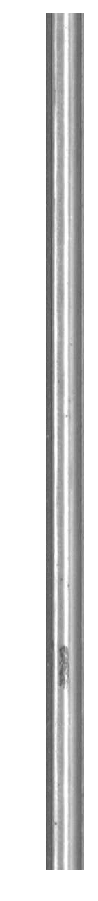

00001.jpg
(1250, 55, 3)
Processing 1 images
image                    shape: (1250, 55, 3)         min:   63.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1250.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -2.12964  max:    2.87866  float32

*** No instances to display *** 



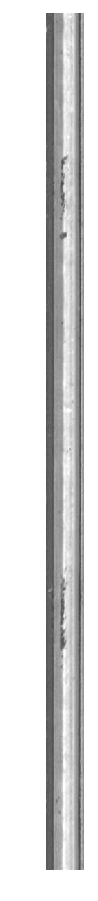

000004.jpg
(1000, 160, 3)
Processing 1 images
image                    shape: (1000, 160, 3)        min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1000.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -2.12964  max:    2.87866  float32

*** No instances to display *** 



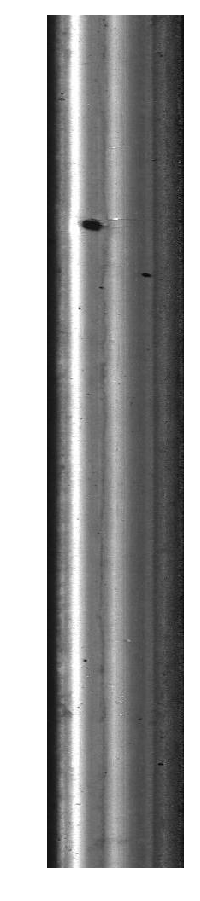

000005.jpg
(1000, 160, 3)
Processing 1 images
image                    shape: (1000, 160, 3)        min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  126.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1000.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -2.12964  max:    2.87866  float32

*** No instances to display *** 



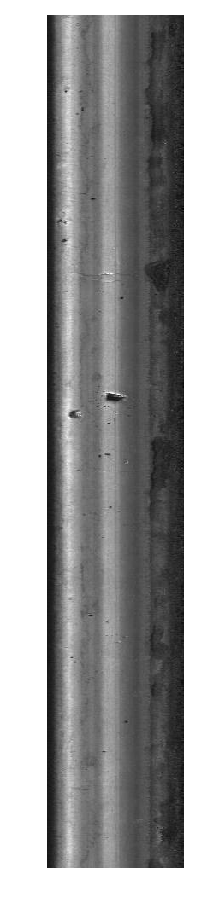

000003.jpg
(1000, 160, 3)
Processing 1 images
image                    shape: (1000, 160, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1000.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -2.12964  max:    2.87866  float32

*** No instances to display *** 



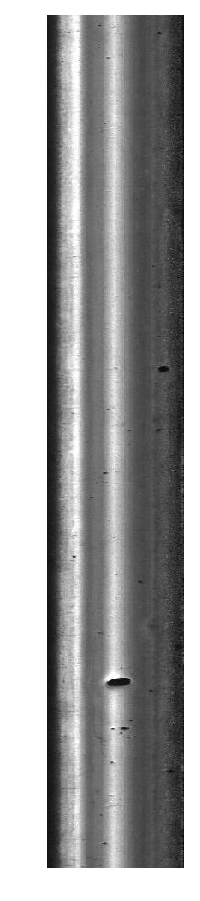

In [16]:
predict()